# Imports and parameters

In [1]:
import os
from multiprocessing import Pool, cpu_count
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.constants as const
from astropy.wcs import WCS
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from PerseusGammaCalibration import persus_model_library
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [43]:
Nmc         = 100          # Number of Monte Carlo trials
reset_mcmc  = True        # Should we restart the MCMC or use existing chains
fit_index   = False       # Fit the spectral index profile

# Define the cluster model

In [3]:
cluster = persus_model_library.default_model()
cluster = persus_model_library.set_magnetic_field_model(cluster, case='Taylor2006')
cluster = persus_model_library.set_pure_hadronic_model(cluster, ('density', 2.0), 2e-3, 2.5)
cluster.Npt_per_decade_integ = 10

# Data

In [4]:
#----- Directory
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')+'Radio'

In [5]:
#---------- Data
tmax_integ0 = 15.0/2*u.arcmin # Radius up to which the flux is integrated (15' == extend, i.e. diameter)
Rmin_prof0  = 30*u.kpc        # Radius down to which the model is acceptable (due to NGC1275)
freq0       = 327*u.MHz       # Frequency at which the profile is extracted
idx_freq1   = 327*u.MHz       # Start frequency for spectral index calculation
idx_freq2   = 609*u.MHz       # End frequency for spectral index calculation

In [6]:
#----- Cosmology correction
cosmo_paper = FlatLambdaCDM(H0=50, Om0=0.3) # Omega_m not given, but very small effect at Perseus redshift
distance_correction = (cosmo.kpc_proper_per_arcmin(cluster.redshift)/cosmo_paper.kpc_proper_per_arcmin(cluster.redshift)).to_value('')
print('Distance correction:', distance_correction)
print('My cosmo: ',cosmo.kpc_proper_per_arcmin(cluster.redshift))
print("Gitti's cosmo: ", cosmo_paper.kpc_proper_per_arcmin(cluster.redshift))

('Distance correction:', 0.7380300923649327)
('My cosmo: ', <Quantity 21.78484574 kpc / arcmin>)
("Gitti's cosmo: ", <Quantity 29.51755757 kpc / arcmin>)


In [7]:
#----- Profile
# Extracted from Gitti's paper
prof_file = dat_dir+'/Perseus_radio_profile_Gitti.txt' 
prof_data1 = pd.read_csv(prof_file, header=None, skiprows=1, index_col=False, names=['radius', 'flux', 'error_m', 'error_p'])
prof_data1['error_m'] = np.log(10)*10**prof_data1['flux'] * prof_data1['error_m'] / 2
prof_data1['error_p'] = np.log(10)*10**prof_data1['flux'] * prof_data1['error_p'] / 2
prof_data1['flux'] = 10**prof_data1['flux']

# Provided by G.F.B.
prof_data2 = {'radius':np.array([239.2,217.8,203.5,192.8,185.7,167.8,153.5,139.2,128.5,110.7,092.8,082.1,067.8,053.6,042.8,039.3,028.6,014.3]), 
             'flux_m':np.array([0.003667,0.003667,0.003643,0.007334,0.011000,0.018340,0.036670,0.036670,0.055010,0.073340,0.073340,0.183400,0.366700,0.550100,0.733400,0.733400,3.667000,14.66800]),
             'flux_p':np.array([0.036670,0.036670,0.018340,0.055010,0.055010,0.091680,0.183400,0.366700,0.366700,0.550100,0.550100,0.733400,0.733400,1.375100,3.667000,3.667000,7.334100,14.66800])}
prof_data2['flux']    = 0.5*(prof_data2['flux_m'] + prof_data2['flux_p'])
prof_data2['error_m'] =  (prof_data2['flux'] - prof_data2['flux_m'])
prof_data2['error_p'] = -(prof_data2['flux'] - prof_data2['flux_p'])

# Combinaning the two
prof_data = {'radius':prof_data2['radius'][::-1]*u.kpc*distance_correction,
             'flux':np.array(prof_data1['flux'])*u.Jy/u.arcmin**2,
             'error_p':np.abs(prof_data2['flux_p'][::-1] - np.array(prof_data1['flux']))*u.Jy/u.arcmin**2,
             'error_m':np.abs(prof_data2['flux_m'][::-1] - np.array(prof_data1['flux']))*u.Jy/u.arcmin**2,
             #'error':0.5*(prof_data2['flux_p'][::-1] - prof_data2['flux_m'][::-1])*u.Jy/u.arcmin**2,
             'error':np.array(prof_data1['flux'])*u.Jy/u.arcmin**2 / 3.0,
             'freq0':freq0,
             'Rmin':Rmin_prof0*distance_correction}

In [8]:
#----- Spectrum
spec_data = {'freq':np.array([327,609,1395])*u.MHz, 
             'flux':np.array([1.2423625254582,0.8798370672098,0.4765784114053]), # This is log F/Jy here
             'error':np.array([0.12219959266803,0.08961303462322,0.05702647657841]),
             'Rmin':Rmin_prof0*distance_correction,
             'Rmax':(tmax_integ0*cosmo.kpc_proper_per_arcmin(cluster.redshift)).to('kpc')}

spec_data['error'] = np.log(10)*10**spec_data['flux'] * spec_data['error'] * u.Jy
spec_data['flux'] = 10**spec_data['flux'] *u.Jy

In [9]:
#----- Spectral index
idx_data = {'radius':np.array([27,46,70,123,169])*u.kpc*distance_correction, 
            'idx':np.array([1.10,1.25,1.55,1.9,2.15]),
            'error':np.array([0.0, 0.125, 0.125, 0.125, 0.125]),
            'freq1':idx_freq1,
            'freq2':idx_freq2,
            'Rmin':Rmin_prof0*distance_correction}

46.2307917974 Jy
(<Quantity 327. MHz>, <Quantity 327. MHz>, <Quantity 17.47280079 Jy>)
('flux correcction', <Quantity 2.64587185>)


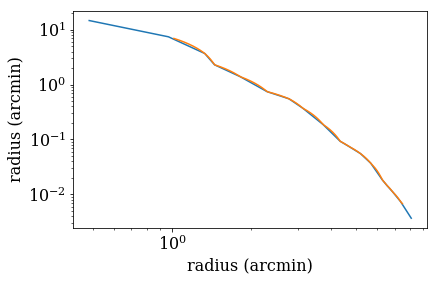

In [10]:
#----- Check the data consistency
# Interpolate the data over a requested range
t_itpl = np.logspace(np.log10((spec_data['Rmin']/cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('arcmin')),
                     np.log10((spec_data['Rmax']/cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('arcmin')),
                     1000)
itpl = interp1d((prof_data['radius']/cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('arcmin'), 
                prof_data['flux'].to_value('Jy arcmin-2'), 
                kind='linear', fill_value='extrapolate')
p_itpl = itpl(t_itpl)

# Check the interpolation
plt.loglog((prof_data['radius']/cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('arcmin'), 
           prof_data['flux'].to_value('Jy arcmin-2'))
plt.loglog(t_itpl, p_itpl)
plt.xlabel('radius (arcmin)')
plt.ylabel('radius (arcmin)')

# Compute the flux expected from the profile
flux_from_profile = minot.model_tools.trapz_loglog(2*np.pi*t_itpl*p_itpl, t_itpl)*u.Jy
flux_correction_factor = flux_from_profile/spec_data['flux'][0]

# Compare to the spectrum
print(flux_from_profile)
print(prof_data['freq0'], spec_data['freq'][0], spec_data['flux'][0])
print('flux correcction',flux_correction_factor)

In [11]:
prof_data['error'] = prof_data['error']/flux_correction_factor
prof_data['flux']  = prof_data['flux']/flux_correction_factor

# Data initial model comparison

In [12]:
frequency = np.logspace(0,5,50)*u.MHz
radius    = np.logspace(0,3,50)*u.kpc

#----- Spectrum
model_ini_freq, model_ini_spec = cluster.get_synchrotron_spectrum(frequency, 
                                                                  Rmin=prof_data['Rmin'], 
                                                                  Rmax=spec_data['Rmax'], 
                                                                  type_integral='cylindrical', Cframe=False)

#----- Profile
model_ini_rad,  model_ini_prof = cluster.get_synchrotron_profile(radius, freq0=prof_data['freq0'], Cframe=True)

#----- Index
model_ini_idxrad, model_ini_idx1 = cluster.get_synchrotron_profile(radius, freq0=idx_data['freq1'])
model_ini_idxrad, model_ini_idx2 = cluster.get_synchrotron_profile(radius, freq0=idx_data['freq2'])
model_ini_idx = -np.log10((model_ini_idx1/model_ini_idx2).to_value('')) / np.log10((idx_data['freq1']/idx_data['freq2']).to_value(''))

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/model_modpar.py:1118: RuntimeWarning: divide by zero encountered in log10
  np.log10(user_p), kind='linear', fill_value='extrapolate')
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


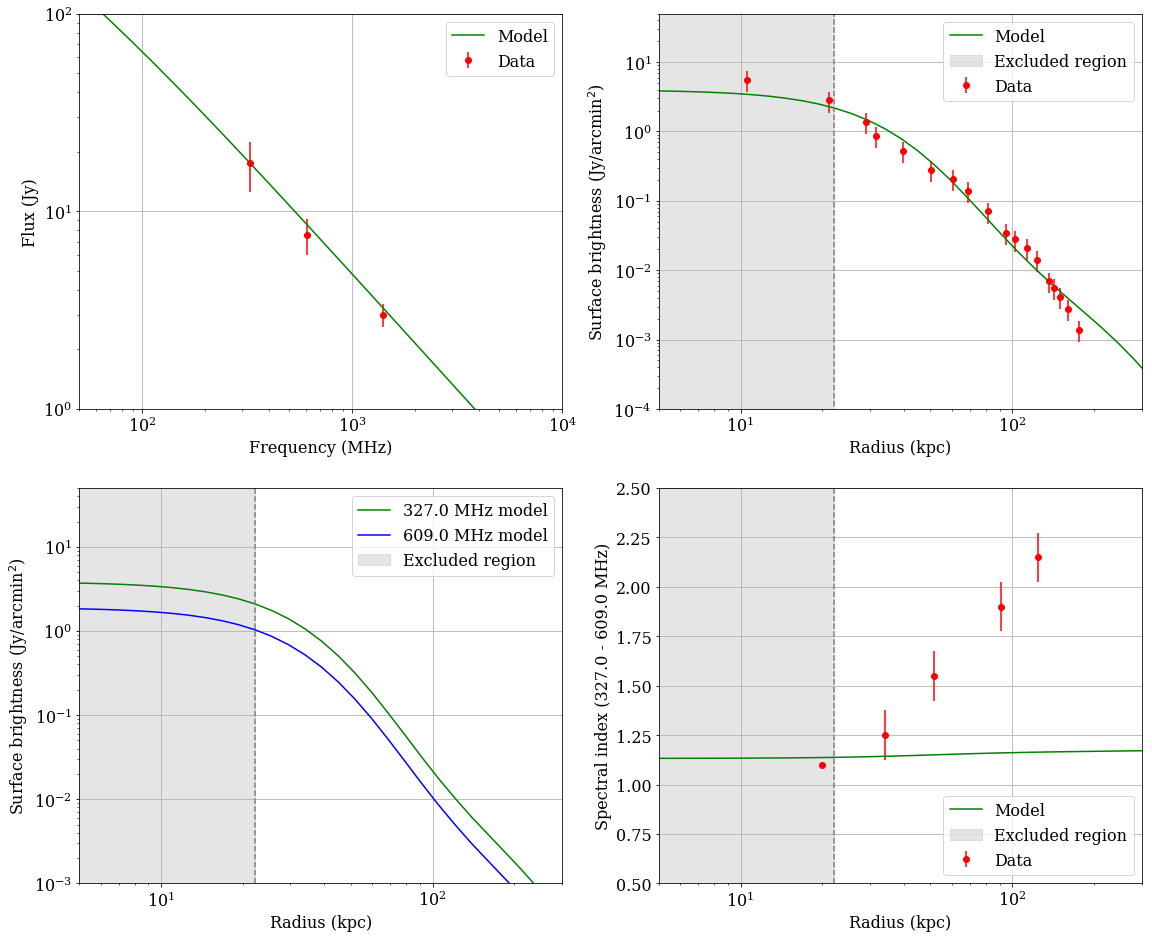

In [13]:
#----- Spectrum
fig = plt.figure(0, figsize=(18, 16))
ax = plt.subplot(221)
plt.errorbar(spec_data['freq'].to_value('MHz'), spec_data['flux'].to_value('Jy'), spec_data['error'].to_value('Jy'),
            marker='o', linestyle='', color='red', label='Data')
plt.plot(model_ini_freq.to_value('MHz'), model_ini_spec.to_value('Jy'), color='green', label='Model')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.xlim(50,10000)
plt.ylim(1,100)
plt.legend()
plt.grid()

#----- Profile
ax = plt.subplot(222)
#plt.errorbar(prof_data['radius'].to_value('kpc'), prof_data['flux'].to_value('Jy arcmin-2'), 
#             yerr=(prof_data['error_m'].to_value('Jy arcmin-2'), prof_data['error_p'].to_value('Jy arcmin-2')),
#             marker='o', linestyle='', color='k')
plt.errorbar(prof_data['radius'].to_value('kpc'), prof_data['flux'].to_value('Jy arcmin-2'), 
             yerr=prof_data['error'].to_value('Jy arcmin-2'),
             marker='o', linestyle='', color='red', label='Data')
plt.plot(model_ini_rad.to_value('kpc'),  model_ini_prof.to_value('Jy arcmin-2'), color='green', label='Model')
plt.plot([prof_data['Rmin'].to_value('kpc'),prof_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,prof_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(5,300)
plt.ylim(1e-4,50)
plt.legend()
plt.grid()

#----- Profile versus frequency
ax = plt.subplot(223)
plt.plot(model_ini_idxrad.to_value('kpc'),  model_ini_idx1.to_value('Jy arcmin-2'), color='green', label=str(idx_data['freq1'].to_value('MHz'))+' MHz model')
plt.plot(model_ini_idxrad.to_value('kpc'),  model_ini_idx2.to_value('Jy arcmin-2'), color='blue', label=str(idx_data['freq2'].to_value('MHz'))+' MHz model')
plt.plot([prof_data['Rmin'].to_value('kpc'),prof_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(5,300)
plt.ylim(1e-3,50)
plt.legend()
plt.grid()

#----- Spectral index
ax = plt.subplot(224)
plt.errorbar(idx_data['radius'].to_value('kpc'), idx_data['idx'], yerr=idx_data['error'],
             marker='o', linestyle='', color='red', label='Data')
plt.plot(model_ini_idxrad.to_value('kpc'),  model_ini_idx, color='green', label='Model')
plt.plot([prof_data['Rmin'].to_value('kpc'),prof_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Radius (kpc)')
plt.ylabel('Spectral index ('+str(idx_data['freq1'].to_value('MHz'))+' - '+str(idx_data['freq2'].to_value('MHz'))+' MHz)')
plt.xlim(5,300)
plt.ylim(0.5,2.5)
plt.legend()
plt.grid()

plt.savefig(cluster.output_dir+'/ResultsCR_test_model')

# MCMC fit

In [14]:
#----- Defines log likelihood
def lnlike(params, cluster, pdata, sdata, idata):
    #--- Priors
    cond1 = params[0]>=0  and params[0]<=1  # X
    cond2 = params[1]>=-5 and params[1]<=5  # eta_CRp
    cond3 = params[2]>=2  and params[2]<=4  # Slope
    if cond1 and cond2 and cond3:
        prof_mod, spec_mod, idx_mod = model(params, cluster, pdata, sdata, idata)
        
        # Profile chi2
        wgood = pdata['radius'] > pdata['Rmin']
        prof_chi2 = ((pdata['flux'].to_value('Jy arcmin-2')[wgood] - prof_mod.to_value('Jy arcmin-2')[wgood])**2)/pdata['error'].to_value('Jy arcmin-2')[wgood]**2

        # Spectrum chi2
        spec_chi2 = ((sdata['flux'].to_value('Jy') - spec_mod.to_value('Jy'))**2)/sdata['error'].to_value('Jy')**2

        # Spectral index chi2
        wgood = idata['radius'] > idata['Rmin']
        idx_chi2 = ((idata['idx'][wgood] - idx_mod[wgood])**2)/idata['error'][wgood]**2
        
        # Chi2 tot
        chi2_tot = -0.5*np.nansum(prof_chi2) - 0.5*np.nansum(spec_chi2)
        if fit_index: 
            chi2_tot = chi2_tot - 0.5*np.nansum(idx_chi2)
        
        return chi2_tot
    else:
        #print('Prior conditions are ', cond1, cond2, cond3, cond4)
        return -np.inf

In [15]:
#----- Defines model
def model(params, cluster, pdata, sdata, idata):
    #--- Extract parameters
    CR_X_E   = params[0]
    CR_eta   = params[1]
    CR_slope = params[2]
    
    #--- Set parameters
    cluster = persus_model_library.set_pure_hadronic_model(cluster, ('density', CR_eta), CR_X_E, CR_slope)
    
    #--- Profile
    r_synch, p_synch = cluster.get_synchrotron_profile(pdata['radius'], freq0=pdata['freq0'])
    
    #--- Spectrum
    sfreq_bis = np.append(np.array([1]), spec_data['freq'].to_value('MHz'))*u.MHz
    s_synch = cluster.get_synchrotron_spectrum(sfreq_bis, Rmin=prof_data['Rmin'],
                                               Rmax=spec_data['Rmax'], type_integral='cylindrical')[1]
    s_synch = s_synch[1:]
    
    #--- Spectral index
    p_synch1 = cluster.get_synchrotron_profile(idata['radius'], freq0=idata['freq1'])[1]
    p_synch2 = cluster.get_synchrotron_profile(idata['radius'], freq0=idata['freq2'])[1]
    i_synch  = -np.log10((p_synch1/p_synch2).to_value('')) / np.log10((idata['freq1']/idata['freq2']).to_value(''))
    
    return p_synch, s_synch, i_synch

In [16]:
#----- Define the MCMC
par0 = np.array([1.5e-3, 2.0, 2.5])

param_name = [r'$X_{CRp}$', r'$\eta_{CRp}$', r'$\alpha_{CRp}$']
ndim, nwalkers, nsteps, burnin = len(par0), 10, 1000, 200
pos = [par0 + par0*1e-1*np.random.randn(ndim) for i in range(nwalkers)]

In [17]:
#----- Define the MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike,     
                                args=[cluster, prof_data, spec_data, idx_data], pool=Pool(cpu_count()))

#----- Restart from where it is or reset
if reset_mcmc:
    sampler.reset()
else:
    try:
        pos = sampler.chain[:,-1,:]
    except:
        print('No sampler available, restart')
        
#----- Rune the MCMC
sampler.run_mcmc(pos, nsteps, progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [4:24:41<00:00, 15.88s/it] 


State([[3.45411450e-03 2.07243907e+00 2.84607947e+00]
 [2.38092936e-03 1.92994754e+00 2.62839411e+00]
 [3.63724290e-03 1.83523438e+00 2.76306020e+00]
 [2.64931727e-03 1.98995407e+00 2.65451116e+00]
 [1.38682394e-03 2.10005261e+00 2.46537659e+00]
 [2.71312493e-03 2.13777019e+00 2.75672134e+00]
 [1.55906324e-03 2.10051611e+00 2.42476138e+00]
 [1.32559988e-03 2.21974300e+00 2.46251624e+00]
 [4.15643501e-03 1.87664801e+00 2.83966880e+00]
 [3.62367260e-03 1.91558907e+00 2.81080251e+00]], log_prob=[ -9.40242781  -8.924985   -11.08417009  -8.26255967  -7.95409351
 -10.30658872 -10.70172714 -10.29008101  -9.86308433  -9.45757135], blobs=None, random_state=('MT19937', array([2498292107,  651355384, 2738782324, 1376072192, 4150419992,
       3077686920, 3191752384, 2048911686, 2978198052, 2079831004,
       1289288089, 3838850655, 2069934244, 1955946634, 2072919562,
       3243869267, 2605087193, 1173706942, 2278329507,  762888182,
        134819028,  714092573, 1277296609, 3470273353, 263357678

In [44]:
#----- Burn in
param_chains = sampler.chain[:, burnin:, :]
lnL_chains = sampler.lnprobability[:, burnin:]

In [45]:
#----- Get the best fit parameters
wbest = (lnL_chains == np.amax(lnL_chains))
param_best = []
for i in range(ndim):
    param_best.append(((param_chains[:,:,i])[wbest])[0])

In [46]:
#----- MC parameters
param_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1],param_chains.shape[2])
Nsample = len(param_flat[:,0])-1
param_MC = np.zeros((Nmc, ndim))
for i in range(Nmc):
    param_MC[i,:] = param_flat[np.random.randint(0, high=Nsample), :] # randomly taken from chains

# Result

### Chains

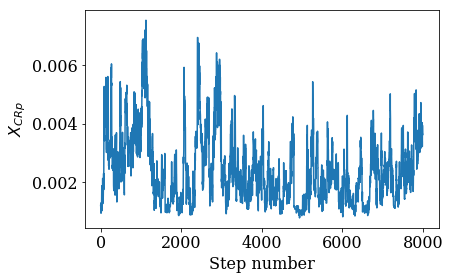

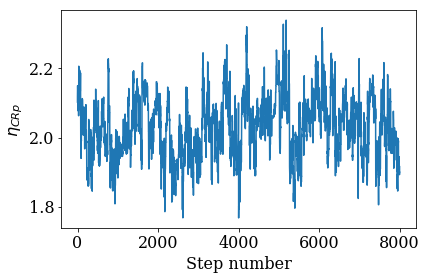

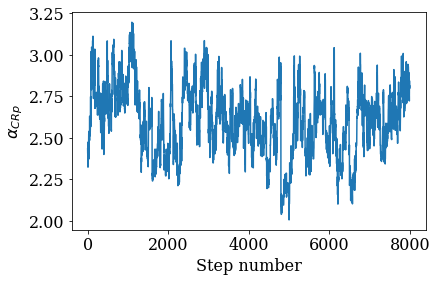

In [47]:
for i in range(ndim):
    plt.figure(i)
    plt.plot((param_chains[:,:,i]).flatten())
    plt.xlabel('Step number')
    plt.ylabel(param_name[i])

### Parameters

In [48]:
print(param_best)

[0.0015987155710613155, 2.054606319185717, 2.486322958128085]


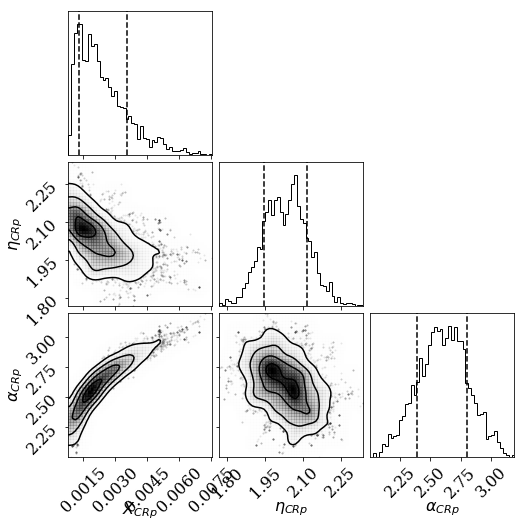

In [92]:
#----- Parameter space
par_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1], param_chains.shape[2])
fig = corner.corner(par_flat, bins=50, color='k', smooth=2, labels=param_name, quantiles=(0.16, 0.84))
fig.savefig(cluster.output_dir+'/Hadronic_triangle_corner.pdf')

### Data versus best-fit

In [82]:
prof_best, spec_best, idx_best = model(param_best, cluster, prof_data, spec_data, idx_data)

In [83]:
prof_mc = []
spec_mc = []
idx_mc  = []

for imc in range(Nmc):
    prof_mci, spec_mci, idx_mci = model(param_MC[imc,:], cluster, prof_data, spec_data, idx_data)
    prof_mc.append(prof_mci)
    spec_mc.append(spec_mci)
    idx_mc.append(idx_mci)

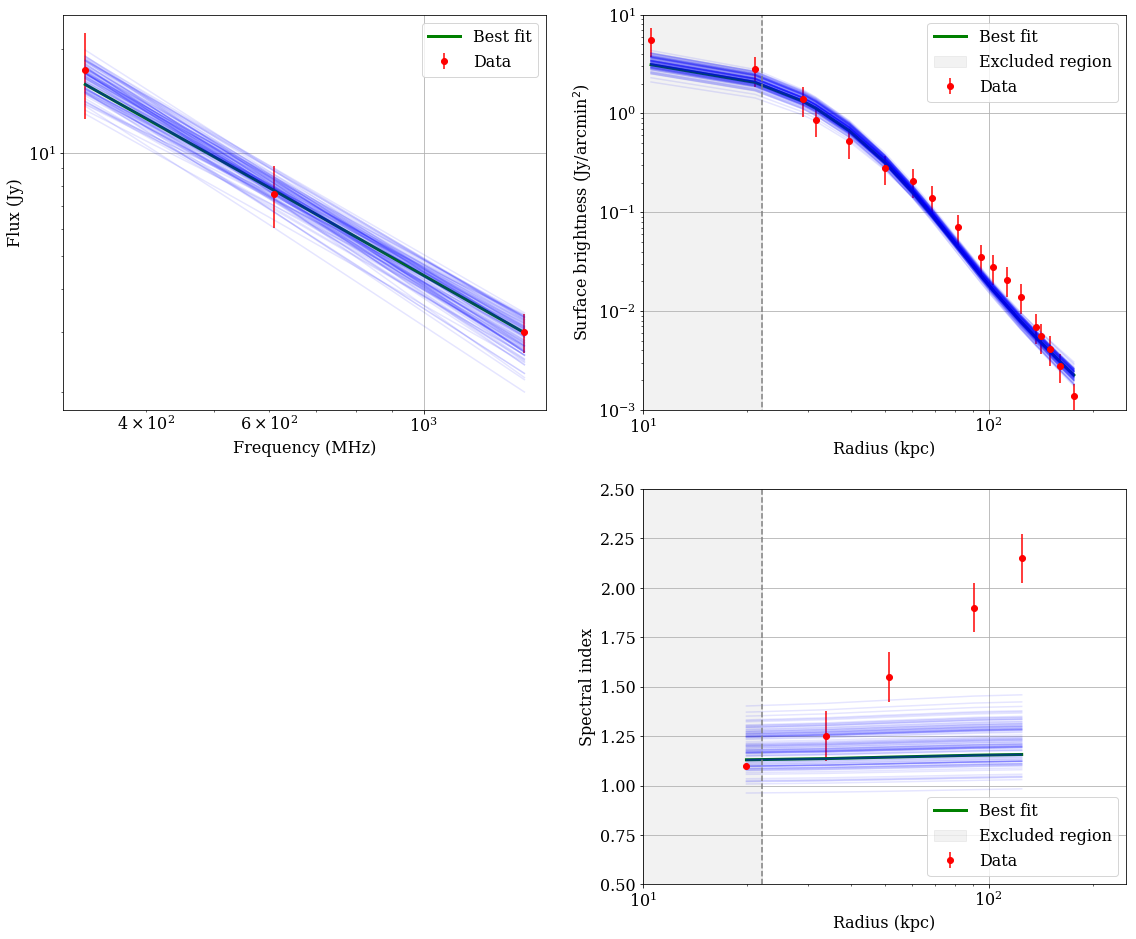

In [86]:
fig = plt.figure(0, figsize=(18, 16))

#----- Spectrum
ax = plt.subplot(221)
plt.errorbar(spec_data['freq'].to_value('MHz'), spec_data['flux'].to_value('Jy'), spec_data['error'].to_value('Jy'),
            marker='o', color='red', linestyle='', label='Data')
plt.plot(spec_data['freq'].to_value('MHz'), spec_best.to_value('Jy'), color='green', linewidth=3, label='Best fit')
for imc in range(Nmc):
    plt.plot(spec_data['freq'].to_value('MHz'), spec_mc[imc].to_value('Jy'), color='blue', alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.legend()
plt.grid()

#----- Profile
ax = plt.subplot(222)
plt.errorbar(prof_data['radius'].to_value('kpc'), prof_data['flux'].to_value('Jy arcmin-2'), 
             yerr=prof_data['error'].to_value('Jy arcmin-2'),
             marker='o', linestyle='', color='red', label='Data')
plt.plot(prof_data['radius'].to_value('kpc'), prof_best.to_value('Jy arcmin-2'), color='green', linewidth=3, label='Best fit')
for imc in range(Nmc):
    plt.plot(prof_data['radius'].to_value('kpc'), prof_mc[imc].to_value('Jy arcmin-2'), color='blue', alpha=0.1)
plt.plot([prof_data['Rmin'].to_value('kpc'),prof_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.1, label='Excluded region')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(10,250)
plt.ylim(1e-3,1e1)
plt.legend()
plt.grid()

#----- Spectral index
ax = plt.subplot(224)
plt.errorbar(idx_data['radius'].to_value('kpc'), idx_data['idx'], yerr=idx_data['error'],
             marker='o', linestyle='', color='red', label='Data')
plt.plot(idx_data['radius'].to_value('kpc'), idx_best, color='green', linewidth=3, label='Best fit')
for imc in range(Nmc):
    plt.plot(idx_data['radius'].to_value('kpc'), idx_mc[imc], color='blue', alpha=0.1)
plt.plot([idx_data['Rmin'].to_value('kpc'),idx_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.1, label='Excluded region')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Radius (kpc)')
plt.ylabel('Spectral index')
plt.xlim(10,250)
plt.ylim(0.5,2.5)
plt.legend()
plt.grid()

In [93]:
#----- Spectrum
fig = plt.figure(0, figsize=(8, 6))
plt.errorbar(spec_data['freq'].to_value('MHz'), spec_data['flux'].to_value('Jy'), spec_data['error'].to_value('Jy'),
            marker='o', color='red', linestyle='', label='Data')
plt.plot(spec_data['freq'].to_value('MHz'), spec_best.to_value('Jy'), color='green', linewidth=3, label='Best fit')
for imc in range(Nmc):
    plt.plot(spec_data['freq'].to_value('MHz'), spec_mc[imc].to_value('Jy'), color='blue', alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.legend()
plt.savefig(cluster.output_dir+'/Haronic_Radio_spectrum.pdf')
plt.close()

#----- Profile
fig = plt.figure(0, figsize=(8, 6))
plt.errorbar(prof_data['radius'].to_value('kpc'), prof_data['flux'].to_value('Jy arcmin-2'), 
             yerr=prof_data['error'].to_value('Jy arcmin-2'),
             marker='o', linestyle='', color='red', label='Data')
plt.plot(prof_data['radius'].to_value('kpc'), prof_best.to_value('Jy arcmin-2'), color='green', linewidth=3, label='Best fit')
for imc in range(Nmc):
    plt.plot(prof_data['radius'].to_value('kpc'), prof_mc[imc].to_value('Jy arcmin-2'), color='blue', alpha=0.1)
plt.plot([prof_data['Rmin'].to_value('kpc'),prof_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.1, label='Excluded region')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(10,250)
plt.ylim(1e-3,1e1)
plt.legend()
plt.savefig(cluster.output_dir+'/Haronic_Radio_profile.pdf')
plt.close()

#----- Spectral index
fig = plt.figure(0, figsize=(8, 6))
plt.errorbar(idx_data['radius'].to_value('kpc'), idx_data['idx'], yerr=idx_data['error'],
             marker='o', linestyle='', color='red', label='Data')
plt.plot(idx_data['radius'].to_value('kpc'), idx_best, color='green', linewidth=3, label='Best fit')
for imc in range(Nmc):
    plt.plot(idx_data['radius'].to_value('kpc'), idx_mc[imc], color='blue', alpha=0.1)
plt.plot([idx_data['Rmin'].to_value('kpc'),idx_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.1, label='Excluded region')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Radius (kpc)')
plt.ylabel('Spectral index')
plt.xlim(10,250)
plt.ylim(0.5,2.5)
plt.legend()
plt.savefig(cluster.output_dir+'/Haronic_Radio_index.pdf')
plt.close()

# Implications for the gamma-rays

In [77]:
energy = np.logspace(-2,6,100)*u.GeV
radius = np.logspace(0,4,100)*u.kpc

E, dN_dEdSdt = cluster.get_gamma_spectrum(energy, 
                                          Rmin=None, Rmax=cluster.R500,
                                          type_integral='cylindrical',
                                          Rmin_los=None, NR500_los=5.0)

r, dN_dSdtdO = cluster.get_gamma_profile(radius, 
                                         Emin=50*u.GeV, Emax=100*u.TeV, 
                                         Energy_density=False, Rmin_los=None, NR500_los=5.0)

In [78]:
prof_g_mc = []
spec_g_mc = []

for imc in range(Nmc):
    cluster = persus_model_library.set_pure_hadronic_model(cluster, ('density', param_MC[imc,1]), 
                                                           param_MC[imc,0], param_MC[imc,2])

    spec_g_mci = cluster.get_gamma_spectrum(energy, Rmin=None, Rmax=cluster.R500,
                                            type_integral='cylindrical',
                                            Rmin_los=None, NR500_los=5.0)[1]

    prof_g_mci = cluster.get_gamma_profile(radius, Emin=50*u.GeV, Emax=100*u.TeV, 
                                           Energy_density=False, Rmin_los=None, NR500_los=5.0)[1]
    prof_g_mc.append(prof_g_mci)
    spec_g_mc.append(spec_g_mci)

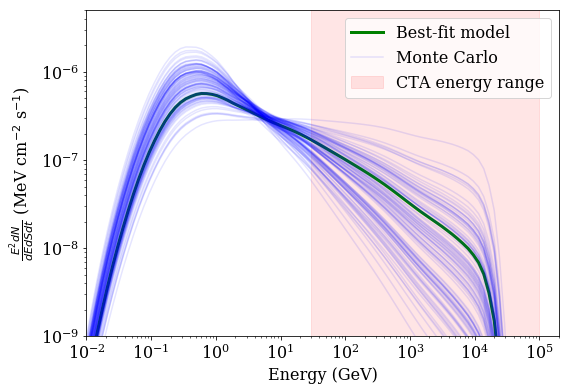

In [90]:
#----- Spectrum
fig = plt.figure(0, figsize=(8, 6))
plt.plot(E.to_value('GeV'), (E**2*dN_dEdSdt).to_value('MeV cm-2 s-1'), color='green', linewidth=3, label='Best-fit model')
for imc in range(Nmc):
    if imc == 0:
        plt.plot(E.to_value('GeV'), (E**2*spec_g_mc[imc]).to_value('MeV cm-2 s-1'), color='blue', alpha=0.1, label='Monte Carlo')
    else:
        plt.plot(E.to_value('GeV'), (E**2*spec_g_mc[imc]).to_value('MeV cm-2 s-1'), color='blue', alpha=0.1)

plt.fill_between([30, 100e3], [0,0], [1e6,1e6], color='red', alpha=0.1, label='CTA energy range')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{E^2 dN}{dEdSdt}$ (MeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 2e5)
plt.ylim(1e-9, 5e-6)
plt.legend()
plt.savefig(cluster.output_dir+'/Haronic_Gamma_spectrum.pdf')

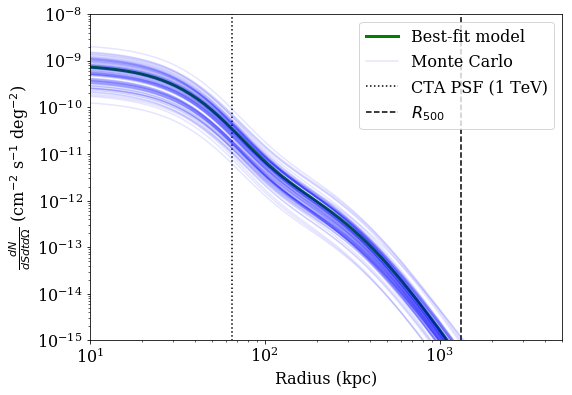

In [91]:
#----- Profile
fig = plt.figure(0, figsize=(8, 6))
plt.plot(r.to_value('kpc'), (dN_dSdtdO).to_value('cm-2 s-1 deg-2'), color='green', linewidth=3, label='Best-fit model')
for imc in range(Nmc):
    if imc == 0:
        plt.plot(r.to_value('kpc'), (prof_g_mc[imc]).to_value('cm-2 s-1 deg-2'), color='blue', alpha=0.1, label='Monte Carlo')
    else:
        plt.plot(r.to_value('kpc'), (prof_g_mc[imc]).to_value('cm-2 s-1 deg-2'), color='blue', alpha=0.1)
plt.vlines((0.05*u.deg*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('kpc'), 0,1, linestyle=':', color='k', label='CTA PSF (1 TeV)')
plt.vlines(cluster.R500.to_value('kpc'), 0,1, linestyle='--', color='k', label='$R_{500}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ deg$^{-2}$)')
plt.xlim(10,5e3)
plt.ylim(1e-15,1e-8)
plt.legend()
plt.savefig(cluster.output_dir+'/Haronic_Gamma_profile.pdf')